## Training and Saving a Machine Learning Model

In [1]:
import pickle
import numpy as np
import pandas as pd
from random import randrange

import matplotlib.pyplot as plt

import urllib.parse
from sqlalchemy import create_engine
import psycopg2

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay)
from sklearn.inspection import permutation_importance

# Disable deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Add location of config.py in grandparent folder to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))
from config import db_password, db_username, db_port

In [2]:
# Set dark theme for matplotlib
plt.style.use('dark_background')

### Load Data from Provisional Database

In [3]:
# Store SQL connection string
db_string = f"postgresql://{db_username}:{urllib.parse.quote(db_password)}\
@127.0.0.1:{db_port}/disease_prediction"

# Connect to SQL database
# Use 'with' to let Python's context manager call Connection.close()
with create_engine(db_string).connect() as engine:
    # Load table from database into DataFrame
    data_df = pd.read_sql_table('disease_cases', engine)
    data_df = data_df.replace([None], np.nan)

In [4]:
# # Load data locally for testing
# data_df = pd.read_csv('./Data/Cleaned/dataset_clean.csv')

data_df.iloc[0:5, 0:6]

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
0,fungal infection,itching,skin rash,nodal skin eruptions,mottling skin,NaN
1,fungal infection,skin rash,nodal skin eruptions,mottling skin,NaN,NaN
2,fungal infection,itching,nodal skin eruptions,mottling skin,NaN,NaN
3,fungal infection,itching,skin rash,mottling skin,NaN,NaN
4,fungal infection,itching,skin rash,nodal skin eruptions,NaN,NaN


### Transform DataFrame to Boolean per Symptom

In [5]:
# List of symptom column names from data_df
symptom_cols = data_df.columns.to_list()[1:]

# Get values from symptom columns as an array
symptom_values = data_df[symptom_cols].values.astype(str)

# Get list of unique values from array
symptom_list = list(np.unique(symptom_values))
symptom_list.remove('nan')

In [6]:
# Create boolean DataFrame
bool_df = data_df.reindex(columns=['Disease'] + symptom_list)

# Apply boolean values to bool_df according to presence in data_df row
for col in bool_df[symptom_list]:
    bool_df[col] = [True if np.isin(row, col).any() else False
                    for row in data_df[symptom_cols].to_numpy()]

# Check that no NaN's remain
print(bool_df.isnull().any().any())

bool_df.iloc[0:5, 0:6]

False


,Disease,abdominal pain,abnormal menstruation,acute liver failure,altered mental state,anxiety
0,fungal infection,False,False,False,False,False
1,fungal infection,False,False,False,False,False
2,fungal infection,False,False,False,False,False
3,fungal infection,False,False,False,False,False
4,fungal infection,False,False,False,False,False


In [7]:
# Save boolean DataFrame
bool_df.to_csv('./Data/Cleaned/dataset_bool.csv')

In [8]:
# Save bool_df to SQL database
with create_engine(db_string).connect() as engine:    
    try:
        bool_df.to_sql(name='dataset_bool',
        con=engine,
        if_exists='fail',
        index=False,
        )
    except ValueError:
        pass

### Split Data into Training and Testing

In [9]:
# Split into features and target arrays
y = bool_df['Disease'].values
X = bool_df.drop(columns=['Disease']).values

In [10]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
	X, y,
	test_size=0.5,		# better for small samples
	random_state=2718281828		# math constant e
)

### Compile Machine Learning Model

#### Decision Tree Classifier - Benchmark Model

In [11]:
dtc = DecisionTreeClassifier(criterion='entropy',
    max_depth=10,
    random_state=2718281828    
)
dtc.fit(X_train, y_train)
dtc_predict = dtc.predict(X_test)

# Calculate accuracy score
accuracy_score(y_test, dtc_predict)

0.9491869918699187

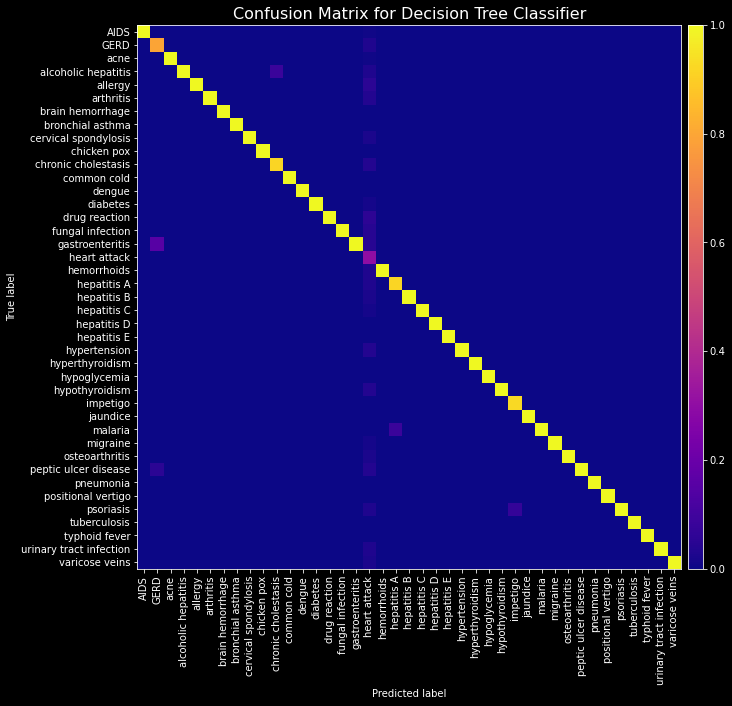

In [12]:
# Generate confusion matrix DTC
dtc_cm = confusion_matrix(y_test, dtc_predict)

# Plot using matplotlib
dtc_fig, dtc_ax = plt.subplots(figsize=(10,10))
dtc_ax.set_title('Confusion Matrix for Decision Tree Classifier',
    fontdict={'fontsize': 16}
)

dtc_display = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=dtc_predict,
    normalize='pred',
    include_values=False,
    xticks_rotation='vertical',
    cmap='plasma',
    ax=dtc_ax,
    colorbar=False
)

# Add custom colorbar
dtc_cax = dtc_fig.add_axes(
    [dtc_ax.get_position().x1 + 0.01,
    dtc_ax.get_position().y0,
    0.02,
    dtc_ax.get_position().height]
)
dtc_cbar = plt.colorbar(dtc_display.im_, cax=dtc_cax)

plt.savefig('./Images/clf_confusion_matrix.png', bbox_inches='tight')

In [13]:
# Show sorted feature importances for DTC
dtc_imp = sorted(zip(dtc.feature_importances_,
    bool_df[symptom_list].columns), reverse=True)
dtc_imp[:3] + dtc_imp[-3:]

[(0.16301904639877193, 'fatigue'),
 (0.10599136577440277, 'vomiting'),
 (0.07107361413843893, 'loss of appetite'),
 (0.0, 'anxiety'),
 (0.0, 'acute liver failure'),
 (0.0, 'abnormal menstruation')]

In [14]:
# Save trained model to Pickle file
pickle.dump(dtc, open('./Models/dtc_model.pkl', 'wb'))

#### Support Vector Machine - Improved Model

In [16]:
# Support Vector Classification
svm = SVC(
    kernel='rbf',	# preferred for nonlinear, unknown data
    gamma=0.5,
    C=0.015,
    random_state=2718281828
)
svm.fit(X_train, y_train)
svm_predict = svm.predict(X_test)

# Calculate accuracy score
accuracy_score(y_test, svm_predict)

0.9605691056910569

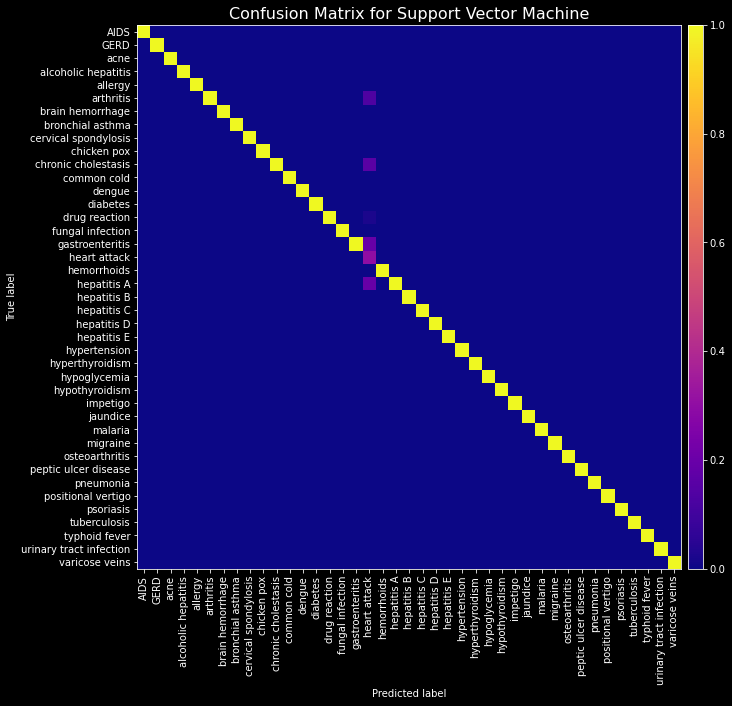

In [17]:
# Generate confusion matrix SVM
svm_cm = confusion_matrix(y_test, svm_predict)

svm_fig, svm_ax = plt.subplots(figsize=(10,10))
svm_ax.set_title('Confusion Matrix for Support Vector Machine',
    fontdict={'fontsize': 16}
)

svm_display = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=svm_predict,
    normalize='pred',
    include_values=False,
    xticks_rotation='vertical',
    cmap='plasma',
    ax=svm_ax,
    colorbar=False
)

# Add custom colorbar
svm_cax = svm_fig.add_axes(
    [svm_ax.get_position().x1 + 0.01,
    svm_ax.get_position().y0,
    0.02,
    svm_ax.get_position().height]
)
plt.colorbar(svm_display.im_, cax=svm_cax)

plt.savefig('./Images/svm_confusion_matrix.png', bbox_inches='tight')

In [17]:
# Show sorted feature importances for SVM
perm_importance = permutation_importance(svm, X_test, y_test,
    n_jobs=-1, random_state=2718281828)

features = np.array(symptom_list)
sorted_idx = perm_importance.importances_mean.argsort()

svm_imp = sorted(zip(perm_importance.importances_mean[sorted_idx],
    features[sorted_idx]), reverse=True)
svm_imp[:3] + svm_imp[-3:]

[(0.026422764227642205, 'itching'),
 (0.023170731707317028, 'abdominal pain'),
 (0.01723577235772351, 'vomiting'),
 (8.130081300812275e-05, 'blister'),
 (0.0, 'rusty sputum'),
 (-0.0044715447154471955, 'skin rash')]

In [18]:
# Save trained model to Pickle file
pickle.dump(svm, open('./Models/svm_model.pkl', 'wb'))

In [249]:
# Check model predictions for a random test case
test_seed = randrange(0, len(X_test))
test_case = X_test[test_seed]

print("Actual: " + y_test[test_seed] + "\n")
print("Model Predictions:")

for x in [dtc, svm]:
    print(f"{x.__class__.__name__}: " +
        x.predict(test_case.reshape(1, -1))[0]
    )

Actual: allergy

Model Predictions:
DecisionTreeClassifier: heart attack
SVC: allergy
